In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector

import numpy as np
import math as m
import scipy as sci
import matplotlib.pyplot as plt

**General Declarations**

In [10]:
N=5
M=2**N

Q=QuantumRegister(N)
C=ClassicalRegister(N)
Koopman=QuantumCircuit(Q,C)

**Specify the function $f(x)$**


In [22]:
sigma = 0.5

f0 =np.zeros((M))
f0 = np.concatenate((np.arange(-M / 2, 0),
                     np.arange(1, M / 2 + 1)))

f_pert = np.random.normal(scale=sigma, size=f0.shape)

f = f0 + f_pert

**Fourier-Walsh expansion of $f(x)$**

In [23]:
def fourier_walsh(f):

    #----Initialize 
    a  = np.zeros((M))
    kk = np.zeros((M,N+1))
    jj = np.zeros((M,N+1))
    ww = np.zeros((M,M))

    #----Fill the last column        
    for i1 in range(0,M):
        kk[i1,N]=i1
        jj[i1,N]=i1

    for i1 in range(0,M): 

    #----Conversion of integer into N-bit string     
        str1=bin(i1)[2:].zfill(N)

        for i2 in range(0,N):
            if str1[i2] == '1':
                kk[i1,i2]=1
                jj[i1,N-1-i2]=1

            if str1[i2] == '0':
                kk[i1,i2]=0
                jj[i1,N-1-i2]=0

    #----Calculate Walsh basis        
    for i1 in range(0,M):
        for i2 in range(0,M):

            np.sum=0
            for i3 in range(0,N):
                np.sum=np.sum + jj[i1,i3]*kk[i2,i3]

            ww[i1,i2] = (-1)**np.sum

    #----Calculate Fourier-Walsh coefficients 
    for i1 in range(0,M):
        np.sum=0

        for i2 in range(0,M):
            np.sum = np.sum + f[i2]*ww[i1,i2]

        a[i1]=np.sum/M
        
    return a, ww

In [24]:
a, ww = fourier_walsh(f)
a0, ww = fourier_walsh(f0)

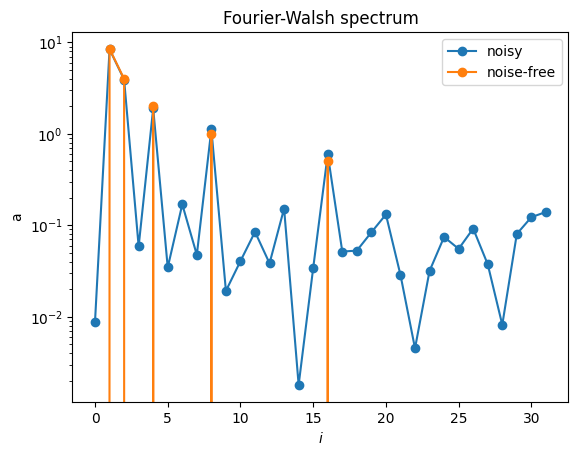

In [26]:
plt.plot(np.abs(a), 'o-', label='noisy')
plt.plot(np.abs(a0), 'o-', label='noise-free')
plt.title('Fourier-Walsh spectrum')
plt.xlabel('$i$')
plt.ylabel('a')
plt.yscale('log')
#plt.axis([0,16,-10, 10])
plt.legend(loc='best')

**Reconstruction of $f(x)$ as test and visualization**

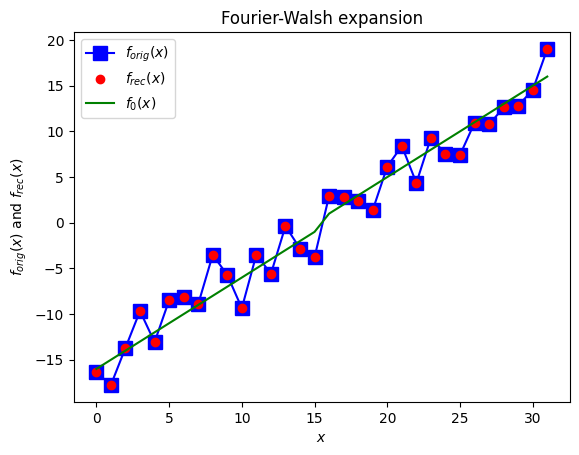

In [21]:
fr=np.zeros((M))

for i1 in range(0,M):
    
    np.sum=0
    for i2 in range(0,M):
        np.sum=np.sum + a[i2]*ww[i1,i2]
            
    fr[i1]=np.sum

#----Plot f(x)
x1=np.zeros((M))

for i1 in range(M):
    x1[i1] = i1
    
plt.plot(x1,f,'bs-',label='$f_{orig}(x)$',markersize=10)
plt.plot(x1,fr,'ro',label='$f_{rec}(x)$',markersize=6)
plt.plot(x1,f0,'g-',label='$f_0(x)$')
plt.title('Fourier-Walsh expansion')
plt.xlabel('$x$')
plt.ylabel('$f_{orig}(x)$ and $f_{rec}(x)$')
#plt.axis([0,16,-10, 10])
plt.legend(loc='best')


**Implementation of the Walsh operators $\hat{w}_0$ to $\hat{w}_{M-1}$**

Note that the operator $\hat{w}_0$ adds a constant phase only. Furthermore, we change the sequence of applications of the Walsh operators.

In [30]:
np.dt=1.0
np.omega=1.0
np.p=-2.0*np.omega*np.dt

#----Input |q3 q2 q1 q0>
Koopman.h(0)   # q0
Koopman.h(1)   # q1 
Koopman.h(2)   # q2
Koopman.h(3)   # q3
    
#----Set barrier
Koopman.barrier()

#----w0
if a[0] != 0:
    print("a[ 0]=",a[0]) 
    
#----w1 
if a[1] != 0:
    print("a[ 1]=",a[1])
    Koopman.rz(a[1]*np.p, 0)

#----w3
if a[3] != 0:
    print("a[ 3]=",a[3])
    Koopman.cx(0,1)
    Koopman.rz(a[3]*np.p, 1)
    Koopman.cx(0,1)

#----w2
if a[2] != 0:
    print("a[ 2]=",a[2])
    Koopman.rz(a[2]*np.p, 1)

#----w6
if a[6] != 0:
    print("a[ 6]=",a[6])
    Koopman.cx(1,2)
    Koopman.rz(a[6]*np.p, 2)
    Koopman.cx(1,2)

#----w7
if a[7] != 0:
    print("a[ 7]=",a[7])
    Koopman.cx(0,2)
    Koopman.cx(1,2)
    Koopman.rz(a[7]*np.p, 2)
    Koopman.cx(1,2)
    Koopman.cx(0,2)

#----w5
if a[5] != 0:
    print("a[ 5]=",a[5])
    Koopman.cx(0,2)
    Koopman.rz(a[5]*np.p, 2)
    Koopman.cx(0,2)

#----w4 
if a[4] != 0:
    print("a[ 4]=",a[4])
    Koopman.rz(a[4]*np.p, 2)

#----w9
if a[9] != 0:
    print("a[ 9]=",a[9])
    Koopman.cx(0,3)
    Koopman.rz(a[9]*np.p, 3)
    Koopman.cx(0,3)

#----w10
if a[10] != 0:
    print("a[10]=",a[10])
    Koopman.cx(1,3)
    Koopman.rz(a[10]*np.p, 3)
#    Koopman.cx(1,3)                # compensates with CNOT in w12 

#----w11
if a[11] != 0:
    print("a[11]=",a[11])
    Koopman.cx(2,3)
    Koopman.rz(a[11]*np.p, 3)
    Koopman.cx(2,3)

#----w12
if a[12] != 0:
    print("a[12]=",a[12])
    Koopman.cx(0,3)
#    Koopman.cx(1,3)                # compensates with CNOT in w10
    Koopman.rz(a[12]*np.p, 3)
    Koopman.cx(1,3)
    Koopman.cx(0,3)

#----w13
if a[13] != 0:
    print("a[13]=",a[13])
    Koopman.cx(0,3)
    Koopman.cx(2,3)
    Koopman.rz(a[13]*np.p, 3)
    Koopman.cx(2,3)
    Koopman.cx(0,3)

#----w14
if a[14] != 0:
    print("a[14]=",a[14])
    Koopman.cx(1,3)
    Koopman.cx(2,3)
    Koopman.rz(a[14]*np.p, 3)
    Koopman.cx(2,3)
    Koopman.cx(1,3)

#----w15
if a[15] != 0:
    print("a[15]=",a[15])
    Koopman.cx(0,3)
    Koopman.cx(1,3)
    Koopman.cx(2,3)
    Koopman.rz(a[15]*np.p, 3)
    Koopman.cx(2,3)
    Koopman.cx(1,3)
    Koopman.cx(0,3)

#----w8
if a[8] != 0:
    print("a[ 8]=",a[8])
    Koopman.rz(a[8]*np.p, 3)

a[ 0]= -0.019053146490347284
a[ 1]= -4.47691271333635
a[ 3]= -0.033722398000459175
a[ 2]= -2.015356116743691
a[ 6]= -0.018914303773466257
a[ 7]= -0.004218866347437511
a[ 5]= 0.006681127901879802
a[ 4]= -0.9947181308727002
a[ 9]= -0.008528126121632562
a[10]= 0.028777639564671054
a[11]= -0.027870095194323763
a[12]= 0.002427105925909112
a[13]= 0.004429040892192981
a[14]= -0.0008496033787416812
a[15]= -0.006486460485869983
a[ 8]= -0.49324462458084145


**Quantum circuit plot and measurement**

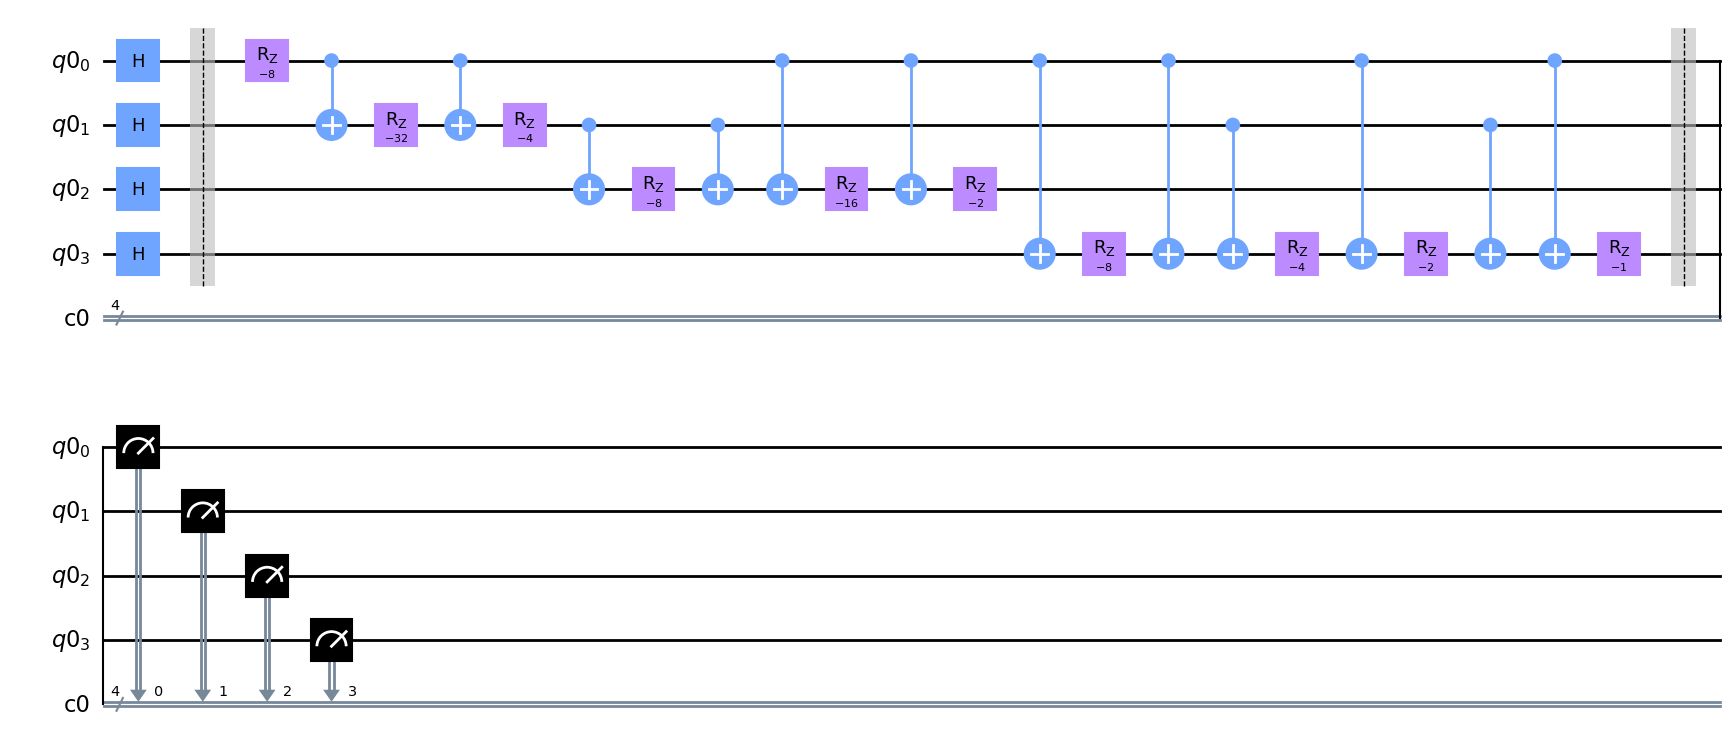

In [8]:
#----Measurement
Koopman.barrier()
Koopman.measure(Q,C)

#----Visualization
Koopman.draw(output='mpl')

{'0101': 5104, '0111': 5062, '1101': 5061, '1111': 5088, '1010': 5155, '1110': 5062, '0100': 5095, '1100': 5122, '1000': 5142, '0010': 5121, '0000': 5141, '0110': 5164, '0011': 5155, '0001': 5278, '1011': 5071, '1001': 5099}


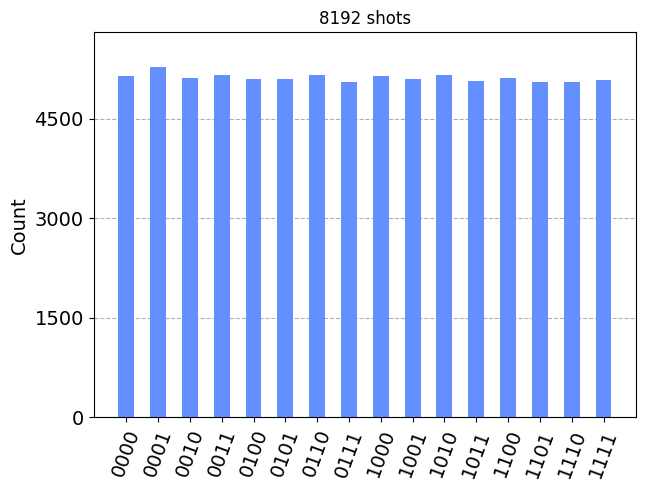

In [9]:
backend = Aer.get_backend('qasm_simulator')
job = execute(Koopman, backend, shots=81920)
result = job.result()
print(result.get_counts())
plot_histogram(result.get_counts(),bar_labels=False,title="8192 shots")